In [2]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="yolov5.tflite")
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [89]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

classes = [ 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush' ]

In [6]:
input_details

[{'name': 'input_1',
  'index': 0,
  'shape': array([  1, 320, 320,   3], dtype=int32),
  'shape_signature': array([  1, 320, 320,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [7]:
output_details

[{'name': 'Identity',
  'index': 422,
  'shape': array([   1, 6300,   85], dtype=int32),
  'shape_signature': array([   1, 6300,   85], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [9]:
input_shape = input_details[0]['shape']
input_shape

array([  1, 320, 320,   3], dtype=int32)

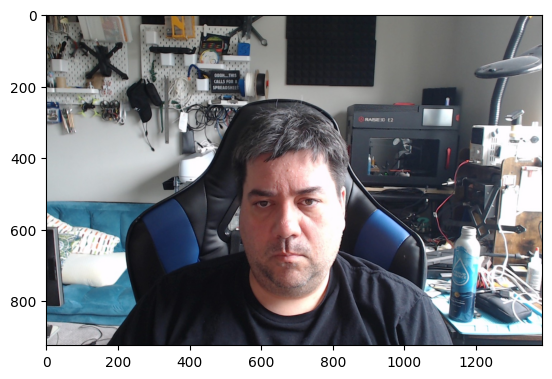

In [199]:
#img = Image.open('table.jpg')
img = Image.open('room.jpg')

# max_dim = max(img.width, img.height)
# padded = Image.new(img.mode, (max_dim,max_dim), 'black')
# padded.paste(img,(0,0))
# img=padded
data = np.array(img.resize(input_shape[1:3],Image.Resampling.LANCZOS), dtype=np.float32)
data /= 255.0
data = data[np.newaxis,...]
plt.imshow(img)

In [200]:
interpreter.set_tensor(input_details[0]['index'], data)
interpreter.invoke()


In [218]:
result = interpreter.get_tensor(output_details[0]['index']).squeeze(0)
boxes = result[...,0:4]
boxes[...,0]*= img.width
boxes[...,1]*= img.height
boxes[...,2]*= img.width
boxes[...,3]*= img.height
scores = result[...,4:5].squeeze()

In [219]:
selected = tf.image.non_max_suppression(
    boxes,
    scores,
    100,
    iou_threshold=0.2,
    score_threshold=0.3
)

In [220]:
for ix in selected:
    res = result[ix,:]
    xywh = boxes[ix,:4]
    conf = res[5:]*res[4:5]
    clas = np.argmax(conf)
    print(xywh, conf[clas], clas, classes[clas])

[662.6492 579.7392 960.5002 681.8099] 0.8372273 0 person
[983.9703  407.9853  272.9346  154.44708] 0.51860344 62 tv
[1175.8251   723.26306   88.64946  270.3656 ] 0.37438744 39 bottle
[326.97955 657.44885 221.67012 331.22635] 0.28675705 56 chair


[662.6492 579.7392 960.5002 681.8099] 0.8372273 0 person
[983.9703  407.9853  272.9346  154.44708] 0.51860344 62 tv
[1175.8251   723.26306   88.64946  270.3656 ] 0.37438744 39 bottle
[326.97955 657.44885 221.67012 331.22635] 0.28675705 56 chair


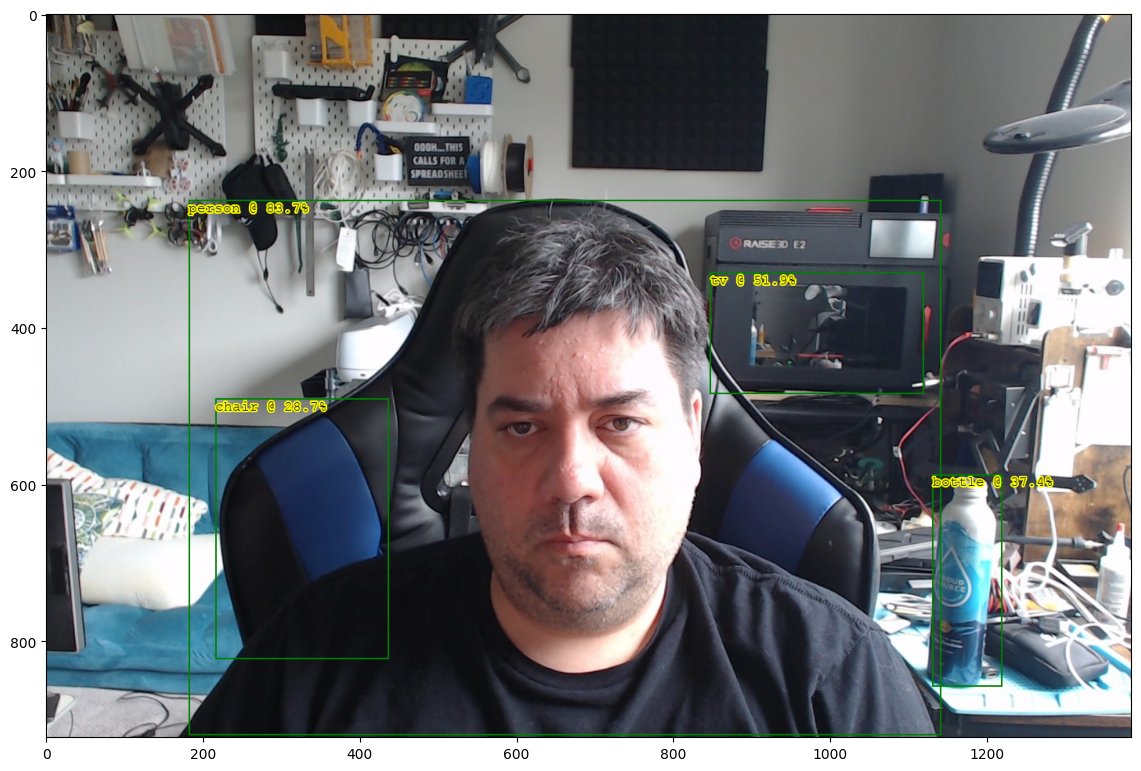

In [221]:
draw_img = img.copy()
drawing = ImageDraw.Draw(draw_img)
f = ImageFont.truetype('Courier New.ttf',18)

for ix in selected:
    res = result[ix,:]
    xywh = boxes[ix,:4]
    conf = res[5:]*res[4:5]
    clas = np.argmax(conf)
    print(xywh, conf[clas], clas, classes[clas])
 
    drawing.rectangle([xywh[0]-xywh[2]/2,xywh[1]-xywh[3]/2, xywh[0]+xywh[2]/2, xywh[1]+xywh[3]/2],outline='green',width=2)
    drawing.text([xywh[0]-xywh[2]/2,xywh[1]-xywh[3]/2],fill='black', stroke_width=2, stroke_fill='yellow',font=f,  text=f'{classes[clas]} @ {conf[clas]*100:.1f}%')
plt.figure(figsize=(14,10))
plt.imshow(draw_img)